In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import plotly.express as px
from sklearn.decomposition import PCA
import numpy as np
import math

# For working with google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip3 install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 157 kB/s 


In [ ]:
# cd gdrive/MyDrive/Colab\ Notebooks/'Deep learning'/Spotify_Popularity_Predictor

!mkdir data
!mkdir images
!cp gdrive/MyDrive/Spotify_Popularity_Predictor/musical_data.csv /content/data/musical_data.csv
!cp gdrive/MyDrive/Spotify_Popularity_Predictor/general_data.csv /content/data/general_data.csv

# Musical Data

List of features:

- key
- mode
- fades
- duration
- tempo
- time signature
- analysis sample rate
- segments timbre (0-399 cols)
- segments start (0-399 cols)
- segments loudness (0-399 cols)
- tatums start (0-499)
- sections_start (0-9)
- bars start (0-99)
- beats start (0-299)

In [ ]:
df = pd.read_csv('data/musical_data.csv')
df = df.dropna(subset=['hotttness'])
df.head()

,hotttness,key,mode,fade_out,fade_in,duration,tempo,time_signature,analysis_sample_rate,segment_timbre_0,...,beats_start_290,beats_start_291,beats_start_292,beats_start_293,beats_start_294,beats_start_295,beats_start_296,beats_start_297,beats_start_298,beats_start_299
1,0.788862,6.960,0.000,0.999999,0.000743,277.28934,98.507,4.000,22050,22.308000,...,0.000000,106.412586,97.879655,74.642206,0.000000,0.000000,17.498250,91.225235,111.330982,82.548038
2,0.345802,1.438,0.865,0.974424,0.000526,205.16526,134.009,0.700,22050,37.863594,...,34.391891,30.733157,55.011211,60.705500,62.622236,0.000000,41.982104,43.187193,30.135193,0.000000
3,0.400040,2.430,0.000,0.964369,0.000000,267.17995,111.810,2.895,22050,22.495299,...,19.466438,0.000000,40.621705,36.952619,67.311986,47.418174,61.834320,41.307767,59.669441,45.789641
4,0.253835,0.894,0.532,0.963616,0.001365,208.11710,103.829,0.000,22050,27.276535,...,57.028326,0.000000,67.753924,0.000000,72.816925,72.376565,54.249821,62.524307,63.245872,0.000000
5,0.000000,5.152,0.687,0.986727,0.002235,201.32526,201.210,2.360,22050,23.796585,...,17.233590,53.394602,61.370891,68.394740,29.952542,59.576071,58.110055,54.637524,37.365042,42.182019


## Auxiliary functions

In [ ]:
def reduce_dimensionality(dataset, n_dimensions):
  """Reduces the size of the dataset to a given parameter"""
  pca = PCA(n_components=n_dimensions)
  return pca.fit_transform(dataset)

def generate_dataset(train_size, val_size):
  df = pd.read_csv('data/musical_data.csv')
  df = df.dropna(subset=['hotttness'])
  scaler = StandardScaler()
  y = df['hotttness'].to_numpy()
  df.drop('hotttness', axis = 1, inplace=True)
  x = scaler.fit_transform(df)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size, shuffle = True)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = train_size, shuffle = True)
  return x_train, y_train, x_test, y_test, x_val, y_val

## View dimensionality reduced features

In [ ]:
indexes = [8, 408, 808, 1208, 1708, 1718, 1818, 2118]
names = ['Segments Timbre', 'Segments Start', 'Segments Loudness', 'Tatums Start', 'Sections Start', 'Bars Start', 'Beats Start']
y = df['hotttness']
df.drop('hotttness', axis=1, inplace=True)
for i in range(len(indexes) - 1):
  coors = reduce_dimensionality(df[df.columns[indexes[i]:indexes[i+1]]], 3)
  for j in range(0, coors.shape[1]):
      coors[:, j] = coors[:, j] / coors[:, j].max()
  aux = pd.DataFrame({'hotttness': y, 'x': coors[:, 0], 'y': coors[:, 1], 'z': coors[:, 2]})
  fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'hotttness')
  fig['layout']['title'] = '%s Distribution'%names[i]
  fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))  
  # fig.write_image('images/%scatter_plot.png'%names[i], scale = 10, width = 1920, height = 1080)
  fig.show()
  

## Preprocessing

Falta anadir cosas y pasarlo a funcion

In [ ]:
def generate_reduced_dataset(train_size, val_size,n):
  # n = number of dimensions of each feature 
  df = pd.read_csv('data/musical_data.csv')
  indexes = [9, 409, 809, 1209, 1709, 1719, 1819, 2119]
  new_df = df[df.columns[:9]]

  for i in range(len(indexes) - 1):
    column = df.columns[indexes[i]]
    new_columns = reduce_dimensionality(df[df.columns[indexes[i]:indexes[i+1]]], round(n))
    for j in range(n):
      new_df[column[:-2]+str(j)]= new_columns[:,j]


  df = new_df
  df = df.dropna(subset=['hotttness'])
  scaler = StandardScaler()
  y = df['hotttness'].to_numpy()
  df.drop('hotttness', axis = 1, inplace=True)
  x = scaler.fit_transform(df)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size, shuffle = True)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = train_size, shuffle = True)
  return x_train, y_train, x_test, y_test, x_val, y_val

In [ ]:
# Preprocessing
indexes = [8, 408, 808, 1208, 1708, 1718, 1818, 2118]
new_coors = []
for i in range(len(indexes) - 1):
  if 'sections' not in df.columns[indexes[i]]:
    new_coors.append(reduce_dimensionality(df[df.columns[indexes[i]:indexes[i+1]]], round(0.1*(indexes[i+1] - indexes[i]))))
  else:
    new_coors.append(reduce_dimensionality(df[df.columns[indexes[i]:indexes[i+1]]], 3))

Now we substitute the initial features by the features obtained after the dimensionality reduction.

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = generate_reduced_dataset(0.8, 0.1,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
x_train.shape

(3614, 29)

## Model Design & Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 6)             42        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 6)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 4)              148       
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 128)               3200      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                          

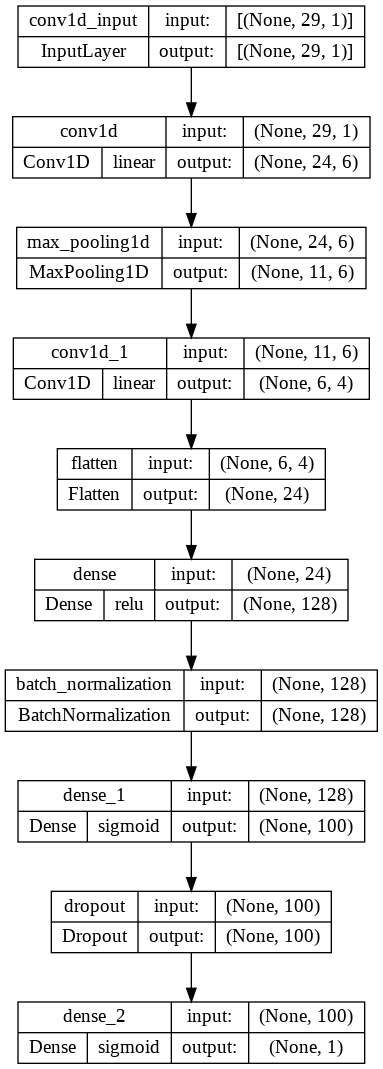

In [ ]:
def generate_model():
  model = Sequential()
  model.add(layers.Conv1D(6, 6, padding='valid', kernel_regularizer='l2', input_shape=(x_train.shape[1], 1)))
  model.add(layers.MaxPooling1D(3, strides=2))
  model.add(layers.Conv1D(4, 6, padding='valid', kernel_regularizer='l2'))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001,))
  model.add(layers.Dense(100, activation ='sigmoid'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation ='sigmoid'))

  model.compile(optimizer=Adam(),
                loss= 'mse',
                metrics=['mae'])
  return model

model = generate_model()
model.summary()
plot_model(model, show_shapes=True, show_layer_activations=True, to_file='images/musical_model.png')

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs = 30, batch_size = 64,
    validation_data=(x_val, y_val)
)

Epoch 1/30
57/57 [==============================] - 2s 10ms/step - loss: 0.1584 - mae: 0.2564 - val_loss: 0.1116 - val_mae: 0.2121
Epoch 2/30
57/57 [==============================] - 0s 6ms/step - loss: 0.1160 - mae: 0.2275 - val_loss: 0.0936 - val_mae: 0.2078
Epoch 3/30
57/57 [==============================] - 0s 6ms/step - loss: 0.1009 - mae: 0.2246 - val_loss: 0.0841 - val_mae: 0.2095
Epoch 4/30
57/57 [==============================] - 0s 6ms/step - loss: 0.0877 - mae: 0.2177 - val_loss: 0.0762 - val_mae: 0.2080
Epoch 5/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0821 - mae: 0.2184 - val_loss: 0.0708 - val_mae: 0.2069
Epoch 6/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0769 - mae: 0.2162 - val_loss: 0.0676 - val_mae: 0.2067
Epoch 7/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0722 - mae: 0.2135 - val_loss: 0.0653 - val_mae: 0.2060
Epoch 8/30
57/57 [==============================] - 0s 7ms/step - loss: 0.0692 - mae: 0.2

In [ ]:
# Convert the history into a df to plot it
name = 'musical_model'

history = history.history
df = pd.DataFrame({'mse': history['loss'],  'mae': history['mae'], 'val_mse': history['val_loss'], 'val_mae': history['val_mae']})
df.index += 1
df.index.name = 'Epochs'

# Plot the accuracy of Training and Validation
fig = px.line(df, x=df.index, y=df['mae'])
fig.add_scatter(x=df.index, y=df['val_mae'], mode='lines')
fig['data'][0].showlegend = True  
fig['data'][0]['name'] = 'Training MAE'
fig['data'][1].showlegend = True
fig['data'][1]['name'] = 'Validation MAE'
fig['layout']['title'] = 'MAE evolution'
fig.write_image('images/%s_MAE.png'%name, scale = 10, width = 1400, height = 480)
fig.show()

# Plot the loss of Training and Validation
fig = px.line(df, x=df.index, y=df['mse'])
fig.add_scatter(x=df.index, y=df['val_mse'], mode='lines')
fig['data'][0].showlegend = True
fig['data'][0]['name'] = 'Training mse'
fig['data'][1].showlegend = True#
fig['data'][1]['name'] = 'Validation mse'
fig['layout']['title'] = 'MSE evolution'
fig.write_image('images/%s_MSE.png'%name, scale = 10, width = 1400, height = 480)
fig.show()

In [ ]:
# Save the model
model.save('gdrive/MyDrive/Spotify_Popularity_Predictor/models/musical_data_model.h5')

# Import model
# new_model = keras.models.load_model('path_to_my_model.h5')

### Test and results analysis

In [ ]:
loss, mae = model.evaluate(x_test, y_test)
print(f"loss:{loss} ")
print(f"mae:{mae} ")

36/36 [==============================] - 0s 2ms/step - loss: 0.0628 - mae: 0.2089
loss:0.06277211010456085 
mae:0.20894953608512878 


In [ ]:
import math
# Predictions
y_pred = model.predict(x_test)

# test dataset plot preparation
coors = reduce_dimensionality(x_test, 3)

# Error difference calculation
abs_difference = []
diff = []
se_difference =[]
for i in range(len(y_test)):
  abs_difference.append(abs(y_pred[i][0] - y_test[i]))
  diff.append(y_pred[i][0] - y_test[i])
  se_difference.append((y_pred[i][0] - y_test[i])**2)

aux = pd.DataFrame({
      'x': coors[:, 0],
      'y': coors[:, 1], 
      'z': coors[:, 2],
      'y_pred': y_pred.reshape(1, -1)[0],
      'y_test': y_test,
      'diff': diff,
      'abs_diff': abs_difference,
      'se_diff': se_difference
  })

36/36 [==============================] - 0s 2ms/step


In [ ]:
aux.head()

,x,y,z,y_pred,y_test,diff,abs_diff,se_diff
0,0.514942,-1.956805,1.924792,0.299738,0.599660,-0.299922,0.299922,0.089953
1,-2.016724,0.943975,1.528482,0.359832,0.000000,0.359832,0.359832,0.129479
2,1.477438,-0.558063,2.207445,0.334861,0.655953,-0.321092,0.321092,0.103100
3,-0.800871,0.125495,-0.617351,0.304125,0.608500,-0.304376,0.304376,0.092644
4,0.488080,-1.766765,0.353002,0.353359,0.563230,-0.209871,0.209871,0.044046


In [ ]:
predicted_mae = sum(aux.abs_diff)/aux.se_diff.shape[0]
print(f"Predicted MAE: {predicted_mae}")
predicted_mse = sum(aux.se_diff)/aux.se_diff.shape[0]
print(f"Predicted MSE: {predicted_mse}")


Predicted MAE: 0.20894953515316503
Predicted MSE: 0.06128928919004818


In [ ]:
# Plot
fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'abs_diff')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = 'Absolute error plot of the test phase'
fig.show()

In [ ]:
# Plot
fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'diff')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = 'Error plot of the test phase'
fig.show()

In [ ]:
# Plot
fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'se_diff')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = 'Squared error plot of the test phase'
fig.show()

In [ ]:
aux['diff'].describe()

count    1130.000000
mean       -0.013696
std         0.247297
min        -0.695688
25%        -0.202569
50%        -0.031193
75%         0.214105
max         0.461381
Name: diff, dtype: float64

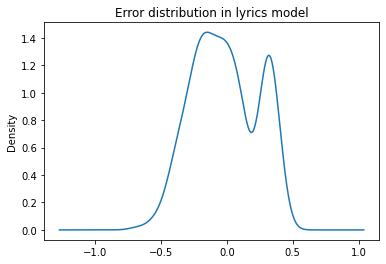

In [ ]:
aux['diff'].plot.kde(title='Error distribution in musical model').figure.savefig('images/lyrics_dataset_error_distribution.png')

In [ ]:
print(aux[aux['diff'] > 0.15])
print(aux[aux['diff'] < -0.15])

             x         y         z    y_pred  y_test      diff  abs_diff  \
1    -2.016724  0.943975  1.528482  0.359832     0.0  0.359832  0.359832   
6    -3.618607 -0.640804  0.233497  0.310816     0.0  0.310816  0.310816   
7     6.328908  0.452072 -0.851657  0.249086     0.0  0.249086  0.249086   
9     2.805484  0.945554  0.999760  0.288713     0.0  0.288713  0.288713   
15   -1.783297  0.120925 -1.326193  0.325898     0.0  0.325898  0.325898   
...        ...       ...       ...       ...     ...       ...       ...   
1112 -0.361928  0.183216  0.472793  0.429240     0.0  0.429240  0.429240   
1118  1.487511 -1.976441  0.800173  0.276525     0.0  0.276525  0.276525   
1119 -1.460375  1.780123 -2.676785  0.316979     0.0  0.316979  0.316979   
1120 -1.899294 -1.382939  2.821620  0.287388     0.0  0.287388  0.287388   
1129 -1.380144  2.680823  1.324302  0.256525     0.0  0.256525  0.256525   

       se_diff  
1     0.129479  
6     0.096607  
7     0.062044  
9     0.083355  
15